# Home Assignment 1

In [0]:
! wget https://www.dropbox.com/sh/21yp77las9uvfza/AABJA-PJXsDbFvh_4ZM3sgnja/eurlex_data.txt

In [0]:
!wget https://www.dropbox.com/sh/21yp77las9uvfza/AAAKnvdvLDHKTLJl-G9Gu1sQa/eurlex_labels.txt

In [4]:
!pip install pyLDAvis

In [0]:
!pip install gensim

In [0]:
!pip install nltk

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [0]:
import numpy as np
import pandas as pd
import gensim
from gensim.test.utils import get_tmpfile
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Сначала импортируем данные. Помним, что соответствие лейблов и текстов неуникально - одному тексту может соответствовать неодинаковое количество лейблов, поэтому импортируем оба файла в разные датафреймы.

In [0]:
eurlex_data = pd.read_csv('eurlex_data.txt', sep = ',', header = None, names = ['label', 'text'])
eurlex_labels = pd.read_csv('eurlex_labels.txt', sep = ' ', header = None, names = ['label_name', 'label', 'x'])
eurlex_labels.drop(['x'], axis = 1, inplace = True)

Теперь посмотрим на сами тексты - это нужно для корректного препроцессинга. Для эксплоративного анализа выберем первые несколько текстов.

In [0]:
for i in range(5):
  print(eurlex_data['text'][i])

Важные на мой взгляд заметки:
1. Тексты написаны на разных языках (что можно было ожидать от датасета, построенного на европейских законах), кроме того, разные языки могут встречаться внутри одного текста - первый выведенный текст начинается по-французски, продолжается по-нидерландски и по-английски.
2. Слова уже обрезаны - это можно заметить по словам во втором выведенном тексте - "exchang letter comiss intern...". Во франкоязычных текстах подобное также можно заметить даже без знания французского. Предполагаю, что стемминг уже проведён и дополнительные стемминг/лемматизация для избавления от различия в морфологических формах не требуются.
3. Нужно понять, есть ли в текстах stop words. Из-за мультиязычности датасета удаление stop words для каждого языка может усложниться. Проверим на первых пяти текстах:

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords

def is_containing_stopwords(text, language = 'english'):
  tokenized_text = word_tokenize(text)
  return (language + ' stopwords - # of tokens as is :' + str(len(tokenized_text)) + 
          ', # of words without stopwords: ' + str(len([i for i in tokenized_text if i not in stopwords.words(language)])))

#first text, observed languages: french, dutch, english
print(is_containing_stopwords(eurlex_data['text'][0], 'french'))
print(is_containing_stopwords(eurlex_data['text'][0], 'dutch'))
print(is_containing_stopwords(eurlex_data['text'][0], 'english'))

#second text, observed languages: english
print(is_containing_stopwords(eurlex_data['text'][1], 'english'))

#third text, observed languages: french, english
print(is_containing_stopwords(eurlex_data['text'][2], 'french'))
print(is_containing_stopwords(eurlex_data['text'][2], 'english'))

#fourth text, observed languages: english
print(is_containing_stopwords(eurlex_data['text'][3], 'english'))

#fifth text, observed languages: english
print(is_containing_stopwords(eurlex_data['text'][4], 'english'))

Можно заметить, что в случае удаления английских stop words количество токенов практически не изменяется - можно предположить, что английские stop words из текстов уже удалены, чего нельзя сказать о stop words для других языков - удаление французских и нидерландских stop words из первого текста серьёзно изменяет количество токенов в нём. Это и наш предыдущий анализ согласуются с найденным описанием датасета (ссылка: http://www.ke.tu-darmstadt.de/resources/eurlex):

*The text was trans­formed to lower case (Low­er­Case­To­k­eniz­er), stop words from a stan­dard En­glish stop word list were re­moved (Stop­Fil­ter), and fi­nal­ly the Porter stem­mer al­go­rithm was ap­plied (Porter­Stem­Fil­ter)*

Посмотрим, много ли текстов используют языки, отличные от английского. Если их доля не очень большая - процедуру очистки текстов от неанглийских stop words можно опустить как не очень значимую.

In [0]:
def num_of_texts_with_letter(corpus, letter):
  t = 0
  for i in range(len(corpus)):
    if corpus[i].find(letter) != -1:
      t += 1
  return t

#german
print(num_of_texts_with_letter(eurlex_data['text'], 'ß'))
#french
print(num_of_texts_with_letter(eurlex_data['text'], 'à'))
#bulgarian
print(num_of_texts_with_letter(eurlex_data['text'], 'м'))
#greek
print(num_of_texts_with_letter(eurlex_data['text'], 'λ'))

Как мы видим, доля таких текстов не очень большая - всего документов около 20 тысяч. На наш взгляд, неанглийские стоп-слова не будут большой проблемой. 
На следующем этапе проведем предобработку лейблов и токенизацию документов - заодно очистим документы от пунктуации.

Наш первый вопрос - все ли документы в принципе имеют темы?

In [0]:
print(len(eurlex_data['label'].unique()))
print(len(eurlex_labels['label'].unique()))


Не все! Такие документы нужно исключить из корпуса - мы не сможем посчитать для них никаких метрик качества.

In [0]:
selected_labels = [i for i in eurlex_data['label'] if i in eurlex_labels['label'].unique()]
selected_docs = eurlex_data[eurlex_data['label'].isin(selected_labels)].reset_index()['text']

In [0]:
tags = []

for i in selected_labels:
  tags.append(' '.join(eurlex_labels[eurlex_labels['label'] == i]['label_name'].tolist()))

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(binary = True)
X_labels = vect.fit_transform(tags)

In [0]:
df_labels = pd.DataFrame(X_labels.toarray(), columns=vect.get_feature_names())
df_labels.head()

In [0]:
import string
documents = []
for i in range(len(selected_docs)):
  doc_tokenized = word_tokenize(selected_docs[i])
  documents.append([j for j in doc_tokenized if i not in list(string.punctuation)][1:-1])

Документы токенизированы, первый и последний токен каждого документа - кавычки определенного формата, их мы отбросили. Можем переходить к первому признаковому пространству - "банальному" bag of words. Мотивация сделать первым именно это пространство - идти от базовых методов к более продвинутым и сравнивать их performance.

### BoW, TfidfVectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features = 500)
X_tfidf = vect.fit_transform(selected_docs).toarray()

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
def roc_auc(y_true, y_pred):
  score = 0
  for i in range(y_true.shape[0]):
    score += roc_auc_score(y_true[i], y_pred[i])
  return score / y_true.shape[0]
def pr_auc(y_true, y_pred):
  score = 0
  for i in range(y_true.shape[0]):
    score += average_precision_score(y_true[i], y_pred[i])
  return score / y_true.shape[0]

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_labels.as_matrix(), test_size = .1, random_state = 42)

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostClassifier, Pool

In [0]:
# Initialize CatBoostClassifier
model_cat = CatBoostClassifier(iterations=2, learning_rate=1, depth=2, loss_function='MultiClass')

In [0]:
ovr_cat = OneVsRestClassifier(model_cat)

In [0]:
# Fit model
ovr_cat.fit(X_tfidf, df_labels.as_matrix())               

0:	learn: -0.1276085	total: 353ms	remaining: 353ms
1:	learn: -0.0433615	total: 608ms	remaining: 0us
0:	learn: -0.1273522	total: 244ms	remaining: 244ms
1:	learn: -0.0429813	total: 509ms	remaining: 0us
0:	learn: -0.1276085	total: 241ms	remaining: 241ms
1:	learn: -0.0433615	total: 506ms	remaining: 0us
0:	learn: -0.1276085	total: 248ms	remaining: 248ms
1:	learn: -0.0433610	total: 506ms	remaining: 0us
0:	learn: -0.1277365	total: 241ms	remaining: 241ms
1:	learn: -0.0435514	total: 512ms	remaining: 0us
0:	learn: -0.1273521	total: 246ms	remaining: 246ms
1:	learn: -0.0429812	total: 500ms	remaining: 0us
0:	learn: -0.1274802	total: 244ms	remaining: 244ms
1:	learn: -0.0431712	total: 496ms	remaining: 0us
0:	learn: -0.1274802	total: 240ms	remaining: 240ms
1:	learn: -0.0431709	total: 497ms	remaining: 0us
0:	learn: -0.1276081	total: 256ms	remaining: 256ms
1:	learn: -0.0433610	total: 507ms	remaining: 0us
0:	learn: -0.1274804	total: 250ms	remaining: 250ms
1:	learn: -0.0431715	total: 503ms	remaining: 0us


In [0]:
# Get predicted classes
preds_class = ovr_cat.predict(X_test) 

In [0]:
# Get predicted probabilities for each class
preds_proba_cat = ovr_cat.predict_proba(X_test)

In [0]:
# Get predicted RawFormulaVal
preds_raw = ovr_cat.predict(test_pool, prediction_type='RawFormulaVal') 

In [0]:
print('roc_auc: ', roc_auc(y_test, preds_proba_cat))
print('pr_auc: ', pr_auc(y_test, preds_proba_cat))

После имплементации самого базового метода хотелось бы перейти на ступеньку выше. Начнём с word2vec.

### Word2Vec

В общем случае, когда необходимо построить некую модель с использованием слов, одним из вариантов может быть использование, например, labeling или one-hot encoding. Однако возникает проблема: такие методы не улавливают значение слов. Word2Vec, напротив, учитывает окружение слов, в чём и заключается преимущество данного метода: могут учитываться различные связи (например, синонимы, антонимы, аналогии). 

Так, основная идея модели ****Word2Vec**** $-$  предсказывать вероятность слова по его контексту. В тоже время метод уменьшает объём данных.

По слову $w$ предсказывается слово $w'$

\\

$X$ – one-hot представление входного слова $w$

$y_i =  p(w' = w_i)$

$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$u_j = W' h$  – выходной слой

$p(w_j) = y_j = \frac{exp(u_j)}{\sum_i exp(u_i)} $ – искомая вероятность

In [0]:
path = get_tmpfile("word2vec.model")
model = gensim.models.Word2Vec(
        documents,
        size=200,
        window=6,
        min_count=1,
        workers=10)

In [0]:
model.train(documents, total_examples=len(documents), epochs=15)
model.save("word2vec.model")

In [0]:
model.wv.most_similar('king')

[('majesti', 0.7037714123725891),
 ('ladi', 0.6278266906738281),
 ('lynn', 0.6255433559417725),
 ('victor', 0.6013976335525513),
 ('jonagold', 0.5900490283966064),
 ('gatehous', 0.589614748954773),
 ('robertson', 0.5895576477050781),
 ('kaiapoi', 0.589528501033783),
 ('jonabr', 0.5887227058410645),
 ('cbe', 0.5870935320854187)]

Параметры на данный момент выбраны дефолтные, затем можно будет поисследовать влияние параметров на качество. Но можно увидеть, что king похоже на queen и majesty - значит, модель работает, ура! (извините, мы с эконома и каждый факт работающего кода очень-очень нас радует).
Попробуем теперь сгенерировать признаки - воспользуемся самым простым методом генерации признаков на базе word2vec - усреднением векторов для каждого слова.

In [0]:
w2v_avg_vec = np.zeros(150)
for doc in tqdm(documents):
  w2v_avg_vec = np.vstack((w2v_avg_vec, np.mean(model[doc], axis = 0)))
w2v_avg_vec = w2v_avg_vec[1:]


In [0]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(w2v_avg_vec, df_labels.as_matrix(), test_size = .1, random_state = 42)

In [0]:
ovr_w2v = OneVsRestClassifier(base_lr)
ovr_w2v.fit(X_train_w2v, y_train_w2v)

In [0]:
y_pred_w2v = ovr_w2v.predict_proba(X_test_w2v)
print('roc_auc: ', roc_auc(y_test_w2v, y_pred_w2v))
print('pr_auc: ', pr_auc(y_test_w2v, y_pred_w2v))

### Визуализация Word2Vec

Теперь попробуем сразу же сделать визуализацию. Сначала расположим слова на плоскости, используя T-SNE (использовали вот такой источник: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne). Очевидно, что если выводить все изображения, то картинка получится перегруженной. Но даже с меньшим количеством слов картинка стандартного размера не вместит нашу визуализацию. Наше решение - достаточно большой min_count и достаточно большой размер графика.

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(60, 60)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [24]:
model_for_viz = gensim.models.Word2Vec(documents,size=100,window=5,min_count=1000,workers=10)
model_for_viz.train(documents, total_examples=len(documents), epochs=10)

(169935932, 240062190)

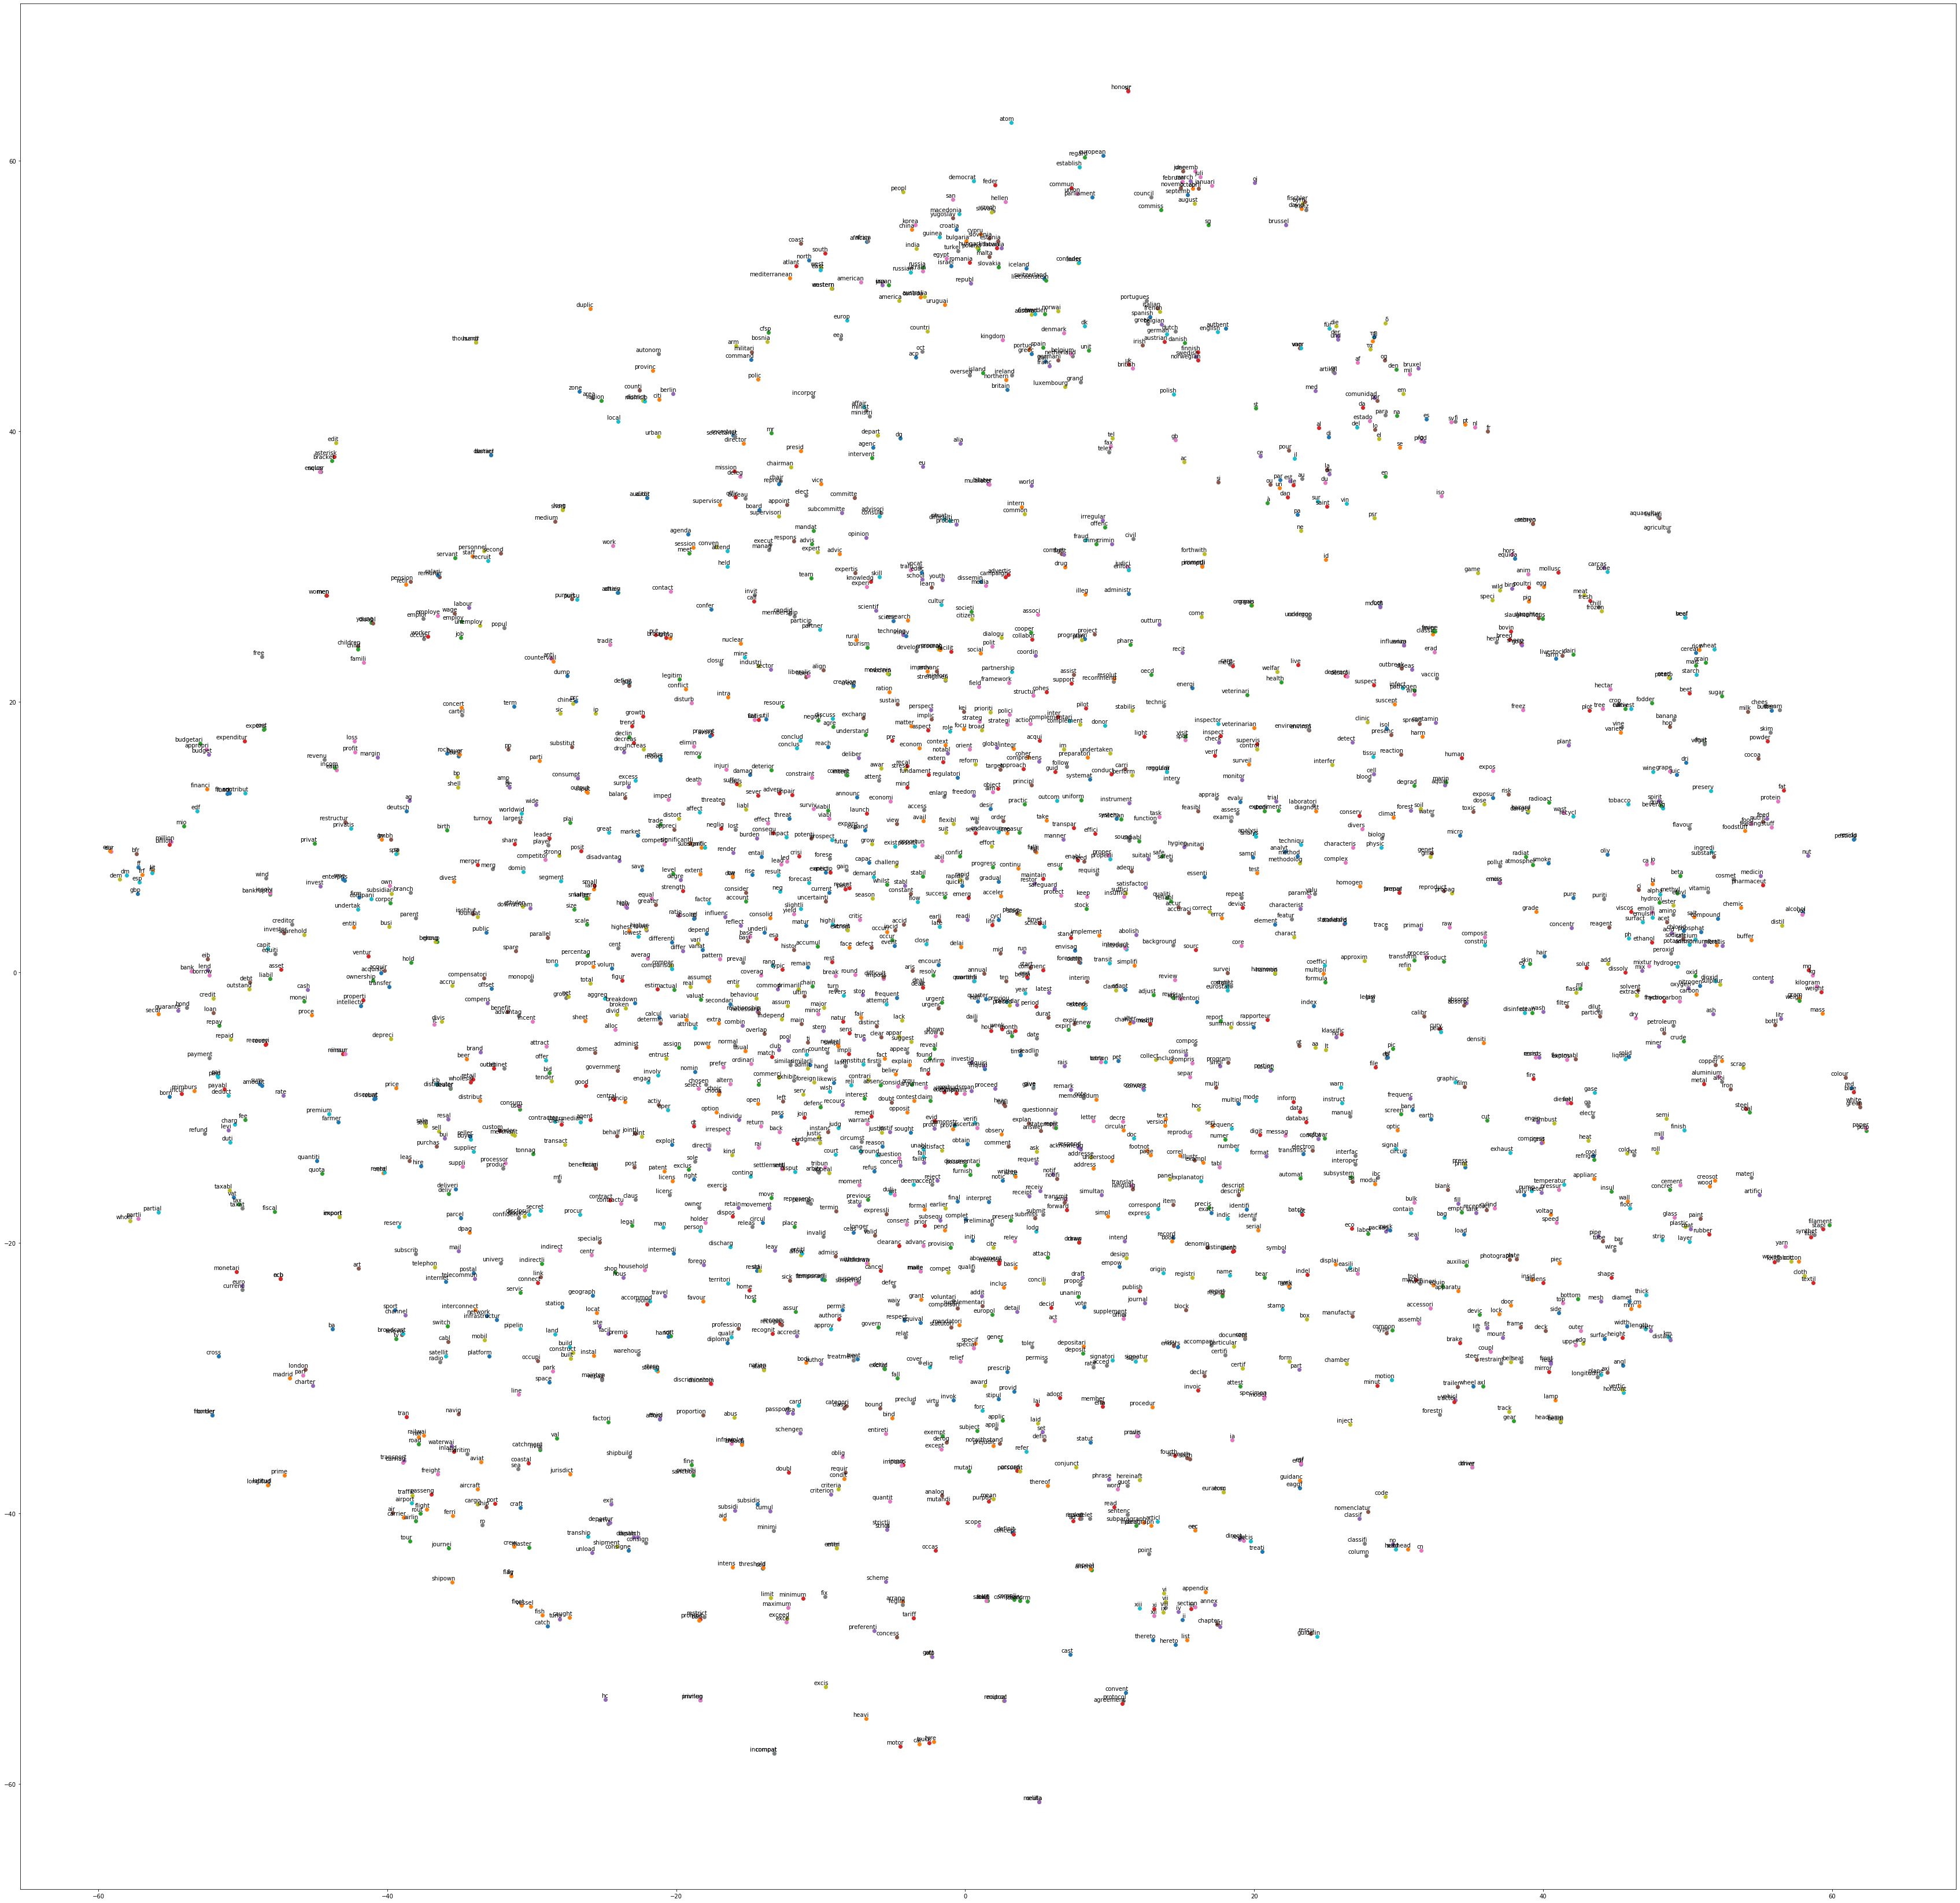

In [25]:
tsne_plot(model_for_viz)

T-SNE неплохо справился с задачей - на картинке легко находятся рядом группы похожих слов :"временные" слова вроде calendar, year, deadline и date, "экономические" - reimburse, payment, repaid, loan, credit, материалы - synthetic, fiber, cotton и так далее. Однако визуализация всё ещё довольно неповоротлива, на ней сложно найти какое-либо конкретное слово, а многих слов на ней просто нет. Попробуем построить визуализацию, которая будет показывать ближайшие слова для каждого конкретного слова (источник вдохновения - https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229).

In [0]:

def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [0]:
display_closestwords_tsnescatterplot(model, 'crop')

Следующим признаковым пространством будет doc2vec.

### Doc2Vec

Метод Doc2Vec - это Word2Vec, но с дополнительной меткой id документа. По факту, этот метод является более общим по причине добавленных векторов абзаца и документа. Т.е. вектор $w$ генерируется для каждого слова, и вектор $d$ - для каждого документа.

Помимо этого, модель Doc2Vec решает проблему игнорирования порядка слов, которая встречается в модели Word2Vec и из-за которой можно потерять важные признаки.

In [0]:
from sklearn.multiclass import OneVsRestClassifier

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [0]:
tagged_data = [TaggedDocument(words = documents[i], tags = tags[i].split()) for i in range(len(documents))]

In [0]:
model_d2v = Doc2Vec(tagged_data, size = 100, window = 20, workers = 10)
model_d2v.save("word2vec.model")

In [0]:
#model_d2v.train(tagged_data, total_examples=len(tagged_data), epochs=10)
#мало времени! попробуем бонусы потом заработать, а пока так

In [32]:
model_d2v.infer_vector(['forest', 'environment', 'pollution', 'ecology'])

array([-0.02261533, -0.03106314, -0.01836857,  0.03788499, -0.00398716,
        0.02322094, -0.00997971, -0.00779418, -0.02992958,  0.01408925,
       -0.04853206,  0.00401021,  0.02818281, -0.01014405, -0.00824253,
        0.00272536,  0.04625241,  0.0168327 ,  0.0106237 ,  0.02181768,
        0.01544094,  0.02128902, -0.00956185, -0.03519661,  0.00130399,
        0.02464985, -0.01356782, -0.03446936, -0.02404973, -0.05828628,
        0.0473194 , -0.05461483,  0.01023265, -0.0114408 ,  0.04473383,
       -0.00244571,  0.03283101, -0.02931284,  0.01996234, -0.02953422,
       -0.01526927,  0.00155162,  0.00461411, -0.00061909,  0.02538306,
        0.00715427, -0.0146286 ,  0.01484219,  0.0061888 , -0.02898363,
        0.00190769,  0.00675987, -0.01602127,  0.01513649, -0.00742542,
        0.04490741,  0.00072169,  0.00403822, -0.01171222, -0.01326193,
        0.0267982 ,  0.00736005,  0.01884464, -0.01426177,  0.00638803,
       -0.01097911, -0.01162168,  0.01062867, -0.03089689,  0.00

In [0]:
d2v_vec = np.zeros(100)
for i in range(len(documents)):
  d2v_vec = np.vstack((d2v_vec, model_d2v.infer_vector(documents[i])))
d2v_vec = d2v_vec[1:]

In [0]:
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(d2v_vec, df_labels.as_matrix(), test_size = .1, random_state = 42)

In [0]:
ovr_d2v = OneVsRestClassifier(base_lr)
ovr_d2v.fit(X_train_d2v, y_train_d2v)

In [0]:
y_pred_d2v = ovr_d2v.predict_proba(X_test_d2v)
print('roc_auc: ', roc_auc(y_test_d2v, y_pred_d2v))
print('pr_auc: ', pr_auc(y_test_d2v, y_pred_d2v))

Теперь переходим к тематическому моделированию.

### Тематическое моделирование: LDA (Latent Dirichlet Allocation)

Существует множество подходов получения тематик текста. Один из таких - TF-IDF. Однако одной из самых популярных методик тематического моделировани является Латентное размещение Дирихле (LDA). LDA рассматривает каждый документ как набор различных тематик. Затем эти темы генерируют слова, основываясь на распределении вероятности. Соответственно, LDA пытается выяснить, какие тематики в первую очередь будет создавать данный набор документов, используя метод матричной факторизации. 

Очевидно, что у одного документа может быть несколько тем; подходы, которые кластеризуют документы по темам, никак этого не учитывают. LDA — это иерархическая байесовская модель, состоящая из двух уровней:
1) на первом уровне – смесь, компоненты которой соответствуют «темам»;
2) на втором уровне – мультиномиальная переменная с априорным распределением Дирихле, которое задаёт «распределение тем» в документе. 
Данная интерпретация модели взята с сайта https://habr.com/company/surfingbird/blog/150607/

На выходе после обучения модели LDA получаются векторы, которые показывают распределение тем в каждом документе, и распределения, показывающие, какие слова более вероятны в различных темах. Как результат, из результатов LDA получается список встречающихся тем для каждого документа, а для каждой темы – список характерных для неё слов.

В модели LDA есть два гиперпараметра: $\alpha$ и $\beta$. $\alpha$ - плотность отношения документов к темам, а $\beta$ - документов к словам. Исходя из распределения ниже, один документ может принадлежать от 1 до 24 категориям. В категорию могут входить от 1 до 1253 текстов. 

Очень помогли разобраться в теме следующие источники:

1) https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

2) https://radimrehurek.com/gensim/models/ldamodel.html

In [38]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
dictionary = corpora.Dictionary(documents)
bow_words = [dictionary.doc2bow(doc) for doc in documents]
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(bow_words, num_topics=30, id2word = dictionary, random_state=42)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [39]:
print(ldamodel.print_topics(num_topics=20, num_words=8))

[(15, '0.021*"product" + 0.011*"milk" + 0.010*"price" + 0.009*"kg" + 0.009*"quot" + 0.008*"weight" + 0.007*"fruit" + 0.007*"butter"'), (23, '0.042*"de" + 0.016*"del" + 0.014*"la" + 0.012*"river" + 0.008*"estado" + 0.007*"di" + 0.007*"lo" + 0.007*"οι"'), (26, '0.039*"fish" + 0.032*"vessel" + 0.019*"fisheri" + 0.013*"water" + 0.011*"ship" + 0.011*"port" + 0.010*"area" + 0.010*"articl"'), (1, '0.065*"δ" + 0.024*"de" + 0.011*"la" + 0.009*"articl" + 0.007*"τα" + 0.007*"en" + 0.006*"fax" + 0.006*"το"'), (25, '0.037*"quot" + 0.015*"articl" + 0.014*"payment" + 0.013*"financi" + 0.011*"member" + 0.010*"state" + 0.009*"account" + 0.009*"asset"'), (14, '0.043*"state" + 0.030*"member" + 0.027*"articl" + 0.011*"convent" + 0.011*"author" + 0.010*"direct" + 0.010*"nation" + 0.010*"person"'), (21, '0.019*"parti" + 0.011*"contract" + 0.010*"cultur" + 0.008*"itl" + 0.006*"articl" + 0.006*"privatis" + 0.006*"agreement" + 0.005*"quot"'), (8, '0.031*"wine" + 0.012*"alcohol" + 0.011*"tv" + 0.010*"pp" + 0.01

In [0]:
ldatopics = ldamodel.show_topics(formatted=False) # сохранили все выделенные топики

### Визуализация LDA (с помощью pyLDAvis)

In [0]:
lda_vis = pyLDAvis.gensim.prepare(ldamodel, bow_words, dictionary)
pyLDAvis.display(lda_vis)

# Бонус

In [0]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
% matplotlib inline

In [0]:
words_wp = []
embeddings_wp = []
for word in list(model.wv.vocab):
    embeddings_wp.append(model.wv[word])
    words_wp.append(word)

In [0]:
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_wp)

In [0]:
from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'War and Peace', embeddings_wp_3d, a=0.1)